In [1]:
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *

Consider the following one-dimensional PDE:
$$
-u_{xx}(x) = f(x)\quad\mathrm{ in }\ \Omega = (0, \pi)
$$
$$
u(x) = 0, \quad\mathrm{ on }\ \partial\Omega = \{0, \pi\}
$$

Given the following $4^{th}$ order finite difference approximation of the second order derivative:

$$u_{xx}(x_i) = \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2}$$

Implement a function that given the domain interval, the forcing function, the number of discretization points (<b> equispaced ?</b>), the boundary conditions, returns the matrix $A$ and the the right hand side $b$.

In [44]:
import sympy as sym

t = sym.var('x')
h = sym.var('h')
g = sym.Function('g')

def cdf_II(t,h,g):
    return (g(t+h)-2*g(t)+g(t-h))/h**2

In [45]:
sym.series(cdf_II(t,h,g), x=h, x0=0, n=5)

Subs(Derivative(g(_xi_1), (_xi_1, 2)), _xi_1, x) + h**2*Subs(Derivative(g(_xi_1), (_xi_1, 4)), _xi_1, x)/12 + h**4*Subs(Derivative(g(_xi_1), (_xi_1, 6)), _xi_1, x)/360 + O(h**5)

In [2]:
def finDif(omega,f,n,bc):
    assert n >= 3 #at least the bounderies + 1 middle point
    assert type(omega) is list
    assert type(bc) is list
    assert len(omega) == 2
    assert len(bc) == 2
    assert omega[0] < omega[-1]
    
    # Get size of each subinterval  (𝑥𝑖,𝑥𝑖+1):
    h = 1./(n-1) 

    # Extract domain boundaries:
    start = omega[0]
    end = omega[-1]
    
    # Evaluate forcing function on grid points:
    x = linspace(start,end,n)
    b = f(x) #rhs
    
    # Using 4𝑡ℎ order FD of 2nd derivative:
    aij2 = 1*ones((n-2,)) # Second Offdiagonal entries
    aij1 = -16*ones((n-1,)) # First Offdiagonal entries
    aii = +30*ones((n,)) # Diagonal entries
    A = (diag(aij2, -2) + diag(aij1, -1) + diag(aii, 0) + diag(aij1, +1) + diag(aij2, +2))
    
    # Change first row of the matrix A and rhs
    A[0,:] = 0
    A[:,0] = 0
    A[0,0] = 1
    b[0] = bc[0]

    # Change last row of the matrix A and rhs
    A[-1,:] = 0
    A[:,-1] = 0
    A[-1,-1] = 1
    b[-1] = bc[-1]
    
    A /= 12*h**2
    
    return A, b

Call the function using:

In [3]:
omega = [0,pi]
f = lambda x : sin(x)
n=100
bc = [0,0]
A, b = finDif(omega, f, n, bc)

print(A)

[[   816.75      0.        0.   ...      0.        0.        0.  ]
 [     0.    24502.5  -13068.   ...      0.        0.        0.  ]
 [     0.   -13068.    24502.5  ...      0.        0.        0.  ]
 ...
 [     0.        0.        0.   ...  24502.5  -13068.        0.  ]
 [     0.        0.        0.   ... -13068.    24502.5       0.  ]
 [     0.        0.        0.   ...      0.        0.      816.75]]


Implement two functions that compute the LU and the Cholesky factorization of the system matrix $A$

In [4]:
def LU(A):
    A = A.copy()
    N=len(A)
    for k in range(N-1):
        if (abs(A[k,k]) < 1e-15):
            raise RuntimeError("Null pivot")
            
        A[k+1:N,k] /= A[k,k]
        for j in range(k+1,N):
            A[k+1:N,j] -= A[k+1:N,k]*A[k,j]
    
    L=tril(A)
    for i in range(N):
        L[i,i]=1.0
    U = triu(A)
    return L, U

L, U = LU(A)

In [5]:
def cholesky(A):
    """Performs a Cholesky decomposition of A, which must 
    be a symmetric and positive definite matrix. The function
    returns the lower variant triangular matrix, L."""
    A = A.copy()
    N = len(A)
    for k in range(N-1):
        A[k,k] = sqrt(A[k,k])
        A[k+1:N,k] = A[k+1:N,k]/A[k,k]
        
        for j in range(k+1,N):
            A[j:N,j] = A[j:N,j] - A[j:N,k]*A[j,k]
        
    A[-1,-1] = sqrt(A[-1,-1])
    L=tril(A)
    return L, L.transpose()

HT, H = cholesky(A)#upper triangular

Implement forward and backward substitution functions to exploit the developed factorization methods to solve the derived linear system of equations.

In [6]:
def L_solve(L,rhs):
    x = zeros_like(rhs)
    N = len(L)
        
    x[0] = rhs[0]/L[0,0]
    for i in range(1,N):
        x[i] = (rhs[i] - dot(L[i, 0:i], x[0:i]))/L[i,i]
    
    return x

In [7]:
def U_solve(U,rhs):
    x = zeros_like(rhs)
    N = len(U)
        
    x[-1] = rhs[-1]/U[-1,-1]
    for i in reversed(range(N-1)):
        x[i] = (rhs[i] - dot(U[i, i+1:N], x[i+1:N]))/U[i,i]
    
    return x

Solve the derived linear system using the implemented functions and plot the computed solution:

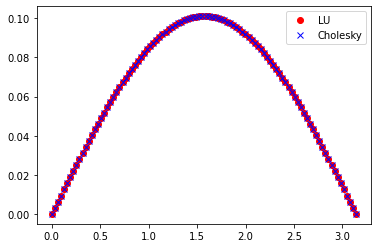

In [8]:
# Using LU
y = L_solve(L,b)
u_LU = U_solve(U,y)

# Using Cholesky
w = L_solve(HT,b)
u_Ch = U_solve(H,w)

x = linspace(omega[0],omega[-1],n)
_ = plot(x,u_LU,'ro', label='LU')
_ = plot(x,u_Ch,'bx', label='Cholesky')
_ = legend()

Considering the new domain $\Omega = (0,1)$ and the forcing term $f(x) = x(1-x)$ with B.C. $u(x) = 0$, on $\partial \Omega = {0,1}$ produce a plot and a table where you show the decay of the error w.r.t. the number of grid points.
(The analytical solution for the above problems is $u_{an} = \frac{x^4}{12} - \frac{x^3}{6} + \frac{x}{12}$)

Let's first try with n=33:

0.00020103342162077278
[[   85.33333333     0.             0.         ...     0.
      0.             0.        ]
 [    0.          2560.         -1365.33333333 ...     0.
      0.             0.        ]
 [    0.         -1365.33333333  2560.         ...     0.
      0.             0.        ]
 ...
 [    0.             0.             0.         ...  2560.
  -1365.33333333     0.        ]
 [    0.             0.             0.         ... -1365.33333333
   2560.             0.        ]
 [    0.             0.             0.         ...     0.
      0.            85.33333333]]
[0.         0.03027344 0.05859375 0.08496094 0.109375   0.13183594
 0.15234375 0.17089844 0.1875     0.20214844 0.21484375 0.22558594
 0.234375   0.24121094 0.24609375 0.24902344 0.25       0.24902344
 0.24609375 0.24121094 0.234375   0.22558594 0.21484375 0.20214844
 0.1875     0.17089844 0.15234375 0.13183594 0.109375   0.08496094
 0.05859375 0.03027344 0.        ]


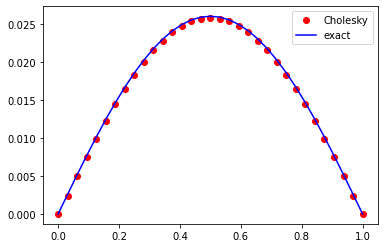

In [9]:
u_ex = lambda x : (x**4)/12. - (x**3)/6. + x/12.
omega = [0,1]
f = lambda x : x*(1.-x)
bc = [0,0]

A, b = finDif(omega, f, 33, bc)
HT, H = cholesky(A)
y = L_solve(HT,b)
u = U_solve(H,y)
x = linspace(omega[0],omega[-1],33)
error = max(abs(u_ex(x)-u))
print(error)


#x = linspace(omega[0],omega[-1],n)
_ = plot(x,u,'ro', label='Cholesky')
_ = plot(x,u_ex(x), 'b', label='exact')
_ = legend()

print(A)
print(b)


Then with $ n \in (3, 300)$:

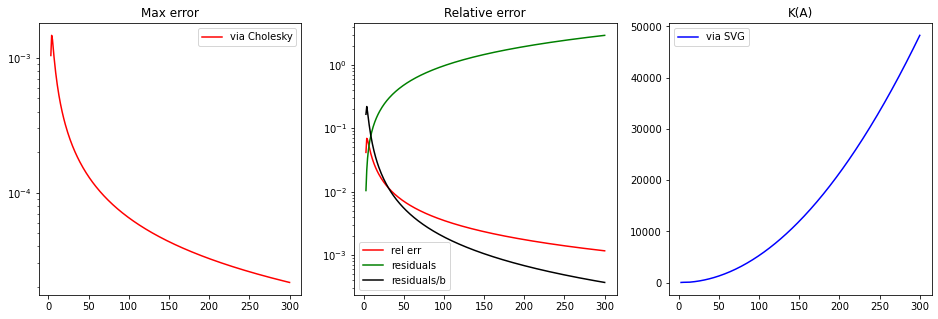

In [38]:
u_ex = lambda x : (x**4)/12. - (x**3)/6. + x/12.
omega = [0,1]
f = lambda x : x*(1.-x)
bc = [0,0]

N = range(3, 301)
max_errors = zeros(len(N))
cond_nums = zeros(len(N))
residuals = zeros(len(N))
rel_errors = zeros(len(N))
residuals_b = zeros(len(N))

for n in N:
    A, b = finDif(omega, f, n, bc)
    HT, H = cholesky(A)
    y = L_solve(HT,b)
    u = U_solve(H,y)
    x = linspace(omega[0],omega[-1],n)
    max_errors[n-3] = max(abs(u_ex(x)-u))
    cond_nums[n-3] = linalg.cond(A)
    residuals[n-3] = linalg.norm(b - dot(A,u_ex(x)),2)
    rel_errors[n-3] = linalg.norm(u_ex(x)-u,2)/linalg.norm(u,2)# euclidean norm
    residuals_b[n-3] = rel_errors[n-3]/linalg.norm(b,2)

#_ = semilogy(N,errors,'r', label='Cholesky')
#_ = legend()

figure, axis = subplots(1, 3, figsize = (16,5))
  
# For Max Errors
axis[0].semilogy(N,max_errors,'r', label='via Cholesky')
axis[0].set_title("Max error")

# For Relative Errors
axis[1].semilogy(N,rel_errors,'r', label='rel err')
axis[1].semilogy(N,residuals,'g', label='r')
axis[1].semilogy(N,residuals_b,'k', label='r/b')
axis[1].set_title("Relative error")

# For Condition number
axis[2].plot(N,cond_nums,'b', label='via SVG')
axis[2].set_title("K(A)")

axis[0].legend(loc='best')
axis[1].legend(loc='best')
axis[2].legend(loc='best')
show()

The relative error infact is bounded by K(A):
$$
\frac{\| x - x_{true} \|}{\| x \|} \leq K(A) \frac{ \| r \|}{\| b \|}
$$

where the norm is the euclidean norm and r is the residual:
$$
r = b -Ax_{true}
$$

In [23]:
print(max(max_errors))
argmax(max_errors) #n=4

0.0014697236919459233


1

Let's investigate for n=4:

0.0014697236919459233
[[  0.75   0.     0.     0.  ]
 [  0.    22.5  -12.     0.  ]
 [  0.   -12.    22.5    0.  ]
 [  0.     0.     0.     0.75]]
[0.         0.22222222 0.22222222 0.        ]


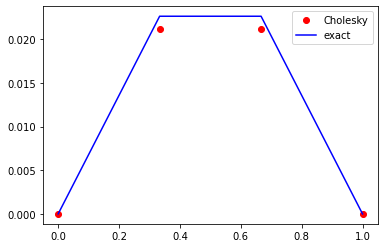

In [24]:
u_ex = lambda x : (x**4)/12. - (x**3)/6. + x/12.
omega = [0,1]
f = lambda x : x*(1.-x)
bc = [0,0]
n=4

A, b = finDif(omega, f, n, bc)
HT, H = cholesky(A)
y = L_solve(HT,b)
u = U_solve(H,y)
x = linspace(omega[0],omega[-1],n)
error = max(abs(u_ex(x)-u))
print(error)


#x = linspace(omega[0],omega[-1],n)
_ = plot(x,u,'ro', label='Cholesky')
_ = plot(x,u_ex(x), 'b', label='exact')
_ = legend()

print(A)
print(b)

Exploit the derived LU factorizations to compute the condition number of the system's matrix $A$ using the original problem formulation.

Recall:
$$
\| A \|_{p=2} = sup_{x \ne 0} \frac{ \| Ax \|_{p=2}}{\| x \|_{p=2}}
$$

But if A is sdp $\implies$
$$
K(A) = \frac{ \lambda_{max}}{\lambda_{min}}
$$

In [47]:
import scipy.linalg

n=100
h = 1./(n-1)
omega = [0,pi]
f = lambda x : sin(x)
bc = [0,0]
A, b = finDif(omega, f, n, bc)
x=linspace(omega[0],omega[-1],n)



def PM(A,z0,tol=1e-5,nmax=500):
    q = z0/numpy.linalg.norm(z0,2)
    it = 0
    err = tol + 1.
    while it < nmax and err > tol:
        z = dot(A,q)
        l = dot(q.T,z)
        err = numpy.linalg.norm(z-l*q,2)
        q = z/numpy.linalg.norm(z,2)
        
        it += 1
    print("error =", err, "iterations =", it)
    print("lambda_max =", l)
    return l,q

def IPM(A,x0,mu,tol=1e-5,nmax=500):
    M = A - mu*eye(len(A))
    P,L,U = scipy.linalg.lu(M)
    q = x0/numpy.linalg.norm(x0,2)
    it = 0
    err = tol + 1.
    while it < nmax and err > tol:
        y = scipy.linalg.solve_triangular(L, dot(P.T,q), lower=True)
        x = scipy.linalg.solve_triangular(U,y)
        z = dot(A,q)
        l = dot(q.T,z)
        err = numpy.linalg.norm(z-l*q,2)
        q = x/numpy.linalg.norm(x,2)
        it += 1
    print("error =", err, "iterations =", it)
    print("lambda =", l)
    return l,q


def condNumb(A):
    #initilal guess
    z0 = ones_like(x)
    l_max,q_max = PM(A,z0)
    l_min,q_min = IPM(A,z0,6.)
    #L, U = LU(A)
    condNu = l_max/l_min
    return condNu

print(condNumb(A))
linalg.cond(A) #2-norm, computed directly using the SVD: 5278 -> very bad

error = 55.65117039403209 iterations = 500
lambda_max = 52189.470999034995
error = 6.011642319811925e-06 iterations = 6
lambda = 9.900512929600458
5271.390620883835


5278.068747923576

Implement a preconditioned Conjugant Gradient method to solve the original linear system of equations using an iterative method:

In [ ]:
def conjugate_gradient(A, b, P, nmax=len(A), eps=1e-10):
    n = len(A)
    x = zeros_like(b)
    tol = eps+1
    count = 0
    r = b - dot(A,x)
    rho_old = 1.
    p_old = zeros_like(b)
    
    while(count<nmax and tol>eps):
        count += 1
        z = linalg.solve(P,r)
        rho = dot(r,z)
        if(count > 1):
            beta = rho/rho_old
            p = z + beta*p_old
        else:
            p = z
        q = dot(A,p)
        alpha = rho/dot(p,q)
        x += p*alpha
        r -= q*alpha
        
        p_old = p
        rho_old = rho
        
        tol = linalg.norm(r,2)
        
    print(count, tol)
    return x

# Recall:
f = x*(1.-x)
f[-1] = 0
f[0] = 0
sol_conjugate_gradient = conjugate_gradient(A, f, identity(len(A)))
#sol_conjugate_gradient

Consider the following time dependent variation of the PDE starting from the orginal problem formulation:
$$
u'(t)-u_{xx} = \alpha(t)f(x)
$$

for $t\in [0,T]$, with $\alpha(t) = \cos(t)$ and $T = 6\pi$

Use the same finite difference scheme to derive the semi-discrete formulation and solve it using a forward Euler's method.

Plot the time dependent solution solution at $x = \pi/2$, $x=1$, 
$x=\pi$


In [ ]:
#TODO

Given the original $Au = b$ system, implement an algorithm to compute the eigenvalues and eigenvectors of the matrix $A$. Exploit the computed LU factorization

In [ ]:
#TODO

Compute the inverse of the matrix A exploiting the derived LU factorization

In [ ]:
#TODO

Consider the following Cauchy problem
$$
\begin{cases}
y'= -ty^2 \quad 0\le t \le 2\\
y(0) = 1
\end{cases}
$$
Implement a Backward Euler's method in a suitable function and solve the resulting non-linear equation using a Newton's method.

In [ ]:
#TODO